In [27]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble, IBMQ, execute
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.visualization import plot_histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import PauliFeatureMap, ZZFeatureMap
from qiskit.opflow import Gradient, NaturalGradient, PauliExpectation, CircuitSampler
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit.algorithms.optimizers import GradientDescent, SPSA, QNSPSA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier, VQC, QGAN, QSVC
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
import copy
from IPython.display import display, Math, Latex

%matplotlib inline

In [2]:
backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 1024, seed_simulator = 2718, seed_transpiler = 2718)
n = 4 # number of qubits

# State Preparation
There is a total of 2$^4$ possible states from a 4-qubit register. `all_states_dict` is used for preparing the initial random four qubit input states to the four qubit output states: $|0011>$, $|0101>$, $|1010>$, $|1100>$. Then `training_states` defines which input state goes to which of the output states. Using the defined input states to output states, 125 samples are created for training the Quantum Neural Network.

In [3]:
all_states = [[a, b, c, d] for a in range(2) for b in range(2) for c in range(2) for d in range(2)]
all_states_dict = {}
for i, e in enumerate(all_states):
    all_states_dict[i] = e
all_states_dict

{0: [0, 0, 0, 0],
 1: [0, 0, 0, 1],
 2: [0, 0, 1, 0],
 3: [0, 0, 1, 1],
 4: [0, 1, 0, 0],
 5: [0, 1, 0, 1],
 6: [0, 1, 1, 0],
 7: [0, 1, 1, 1],
 8: [1, 0, 0, 0],
 9: [1, 0, 0, 1],
 10: [1, 0, 1, 0],
 11: [1, 0, 1, 1],
 12: [1, 1, 0, 0],
 13: [1, 1, 0, 1],
 14: [1, 1, 1, 0],
 15: [1, 1, 1, 1]}

In [4]:
output_states = [3, 5, 10, 12]

def random_states():
    states = []
    str_inp_states = []
    
    while len(states) < 4:
        qc = QuantumCircuit(4)
        qc.h(range(4))
        qc.measure_all()
        sim = Aer.get_backend('statevector_simulator')
        input_state = list(sim.run(assemble(qc)).result().get_counts())[0]
        if input_state not in str_inp_states:
            output_state = len(states)
            str_inp_states.append(input_state)
            input_state = [int(x) for x in list(input_state)]
            output_state_list = all_states_dict[output_states[output_state]]
            states.append([input_state, output_state_list])
            
    a = []
    for s in states:
        a0 = s[0]
        for a1 in s[1]:
            a0.append(a1)
        if len(s) == 3:
            for a1 in s[2]:
                a0.append(a1)
        a.append(a0)
    
    return a

In [5]:
training_states = random_states()
training_states

[[0, 0, 1, 1, 0, 0, 1, 1],
 [1, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 1, 1, 1, 1, 0, 0]]

In [6]:
training_input_states = [''.join([str(x) for x in i[:4]]) for i in training_states]

In [7]:
inp_out_states = {
    training_input_states[0]: '0011',
    training_input_states[1]: '0101',
    training_input_states[2]: '1010',
    training_input_states[3]: '1100'
}
inp_out_states

{'0011': '0011', '1101': '0101', '1000': '1010', '0111': '1100'}

In [8]:
def list_str(l):
    l = ''.join([str(x) for x in l])
    return l

In [9]:
df = pd.DataFrame({})
features = [f'x{i}' for i in range(4)]
target = [f'y{i}' for i in range(4)]

for i in range(125):
    choice = np.array(training_states[np.random.randint(0, 4)])
    df = df.append([choice.ravel().tolist()], ignore_index=True)
df.columns = features + target

In [10]:
df.head()

,x0,x1,x2,x3,y0,y1,y2,y3
0,1,0,0,0,1,0,1,0
1,0,0,1,1,0,0,1,1
2,1,1,0,1,0,1,0,1
3,0,0,1,1,0,0,1,1
4,0,1,1,1,1,1,0,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[features].to_numpy(), df[target].to_numpy(), test_size=0.2)

# Feature Map
The use of the feature map does applies an $X$ gate on the qubits that were defined as having an input state of 1.

In [12]:
def feature_map(X_i):
    qc = QuantumCircuit(4)
    
    for i in range(4):
        if X_i[i]:
            qc.x(i)
    
    return qc

# Variational Circuit
Due to this complex problem of choosing the right variational circuit to determine the output state, refering to $\textit{Benedetti, M., Garcia-Pintos, D.,}$ $\textit{Perdomo, O. et al.}$ $\textit{A generative modeling approach for benchmarking and training shallow quantum circuits.}$ $\textit{npj Quantum Inf 5, 45 (2019).}$ https://doi.org/10.1038/s41534-019-0157-8 made this approach easier. There was provided three cost function circuits from the [Supplementary Material](https://static-content.springer.com/esm/art%3A10.1038%2Fs41534-019-0157-8/MediaObjects/41534_2019_157_MOESM1_ESM.pdf) where they are created below using $\textit{Qiskit's Circuit Library}$:
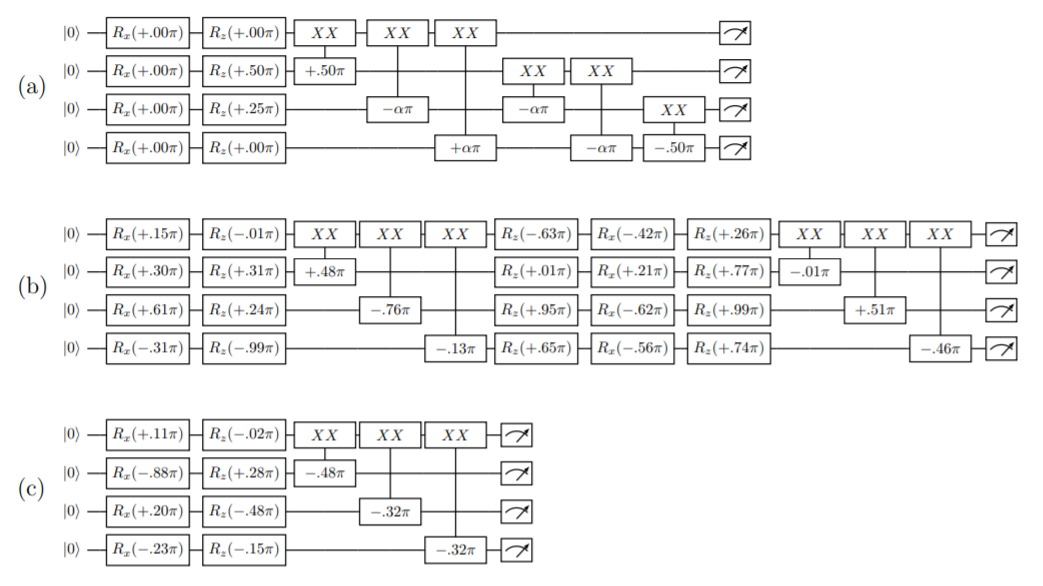

In [13]:
def variational_circuit_a(qc, theta):
    # theta length = 14
    
    for i in range(4):
        qc.rx(theta[i], i)
        
    for i in range(4):
        qc.rz(theta[i+4], i)
        
    for i in range(3):
        qc.rxx(theta[i+8], 0, 1+i)
        
    for i in range(2):
        qc.rxx(theta[i+11], 1, 2+i)
        
    qc.rxx(theta[13], 2, 3)
    
    return qc

In [14]:
def variational_circuit_b(qc, theta):
    # theta length = 27
    
    for i in range(4):
        qc.rx(theta[i], i)
        
    for i in range(4):
        qc.rz(theta[i+4], i)
        
    for i in range(3):
        qc.rxx(theta[i+8], 0, 1+i)
        
    for i in range(4):
        qc.rz(theta[i+11], i)
        
    for i in range(4):
        qc.rx(theta[i+15], i)
        
    for i in range(4):
        qc.rz(theta[i+19], i)
    
    for i in range(3):
        qc.rxx(theta[i+23], 0, 1+i)
    
    return qc

In [15]:
def variational_circuit_c(qc, theta):
    # theta length = 12
    
    for i in range(4):
        qc.rx(theta[i], i)
        
    for i in range(4):
        qc.rz(theta[i+4], i)
        
    for i in range(3):
        qc.rxx(theta[i+8], 0, 1+i)
    
    return qc

# Quantum Neural Network
The Quantum Neural Network was made with the above Feature Map, a singular Variational Circuit (specified in the function), and measurements to classical bits. To have good results, 2$^1$^0$ or 1024 shots were taken executed on a simulated noisy quantum computer. The loss was determined through comparing the difference in the prediction and target squared. The gradient was used to update theta based on the derivative for a distance of `delta=0.01`. The accuracy was defined as the number of correct classifications of the quantum neural network. Lastly, to train the quantum neural network, 25 epochs were done over `Variational Circuit B` because it had the most parameters. To see the loss and accuracy over time, those were plotted.

In [16]:
def qnn(X_i, theta, c):
    qc = feature_map(X_i)
    if c == 'a':
        qc = variational_circuit_a(qc, theta)
    elif c == 'b':
        qc = variational_circuit_b(qc, theta)
    elif c == 'c':
        qc = variational_circuit_c(qc, theta)
        
    qc.measure_all()
    
    shots = 1024
    backend = Aer.get_backend('qasm_simulator')
    
    job = qiskit.execute(qc, backend, shots=shots)
    counts = job.result().get_counts(qc)
    
    counts = sorted(counts.items(), key=lambda x: -x[1])

    return [int(x) for x in list(counts[0][0])]

In [17]:
def loss(prediction, target):
    cts = np.sum([prediction[i] == target[i] for i in range(4)])
    return cts ** 2

In [18]:
def gradient(X_i, y_i, theta, circuit_type):
    delta = 0.01
    grad = []
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        prediction1 = qnn(X_i, dtheta, circuit_type)
        prediction2 = qnn(X_i, theta, circuit_type)
        
        grad.append((loss(prediction1, y_i) - loss(prediction2, y_i)) / delta)
        
    return np.array(grad)

In [19]:
def accuracy(X, y, theta, circuit_type):
    cts = 0
    for X_i, y_i in zip(X, y):
        prediction = qnn(X_i, theta, circuit_type)
        pred_cts = 0
        for X_ij, y_ij in zip(X_i, y_i):
            if X_ij == y_ij:
                pred_cts += 1
        if pred_cts == 4:
            cts += 1
            
    return cts / len(y)

In [20]:
def train_qnn(X, y, circuit_type, eta=0.05, epochs=20, theta=None):
    if theta == None:
        theta_len = 14 if circuit_type == 'a' else 26 if circuit_type == 'b' else 11
        theta = np.array([(np.random.rand()-0.5)*np.pi*2 for i in range(theta_len)])
        
#     acc = accuracy(X, y, theta, circuit_type)
#     while acc == 0:
#         theta = np.array([(np.random.rand()-0.5)*np.pi*2 for i in range(theta_len)])
#         acc = accuracy(X, y, theta, circuit_type)
        
    loss_list = []
    accuracy_list = []
    print('Epoch \t \t Loss \t \t Training Accuracy')
    
    for i in range(epochs):
        loss_temp = []
        for X_i, y_i in zip(X, y):
            prediction = qnn(X_i, theta, circuit_type)
            loss_temp.append(loss(prediction, y_i))
            theta = theta - eta * gradient(X_i, y_i, theta, circuit_type)
        loss_list.append(np.mean(loss_temp))
        acc = accuracy(X, y, theta, circuit_type)
        accuracy_list.append(acc)
        
        print(f'{i} \t \t \t {loss_list[-1]:.3f} \t \t \t {acc:.5f}')
        
    return loss_list, accuracy_list, theta

In [21]:
loss_list, accuracy_list, theta = train_qnn(X_train, y_train, 'b', epochs=25)

Epoch 	 	 Loss 	 	 Training Accuracy
0 	 	 	 9.090 	 	 	 0.23000
1 	 	 	 9.090 	 	 	 0.23000
2 	 	 	 9.090 	 	 	 0.23000
3 	 	 	 9.090 	 	 	 0.23000
4 	 	 	 9.090 	 	 	 0.23000
5 	 	 	 9.090 	 	 	 0.23000
6 	 	 	 9.090 	 	 	 0.23000
7 	 	 	 9.090 	 	 	 0.23000
8 	 	 	 9.090 	 	 	 0.23000
9 	 	 	 9.090 	 	 	 0.23000
10 	 	 	 9.090 	 	 	 0.23000
11 	 	 	 9.090 	 	 	 0.23000
12 	 	 	 9.090 	 	 	 0.23000
13 	 	 	 9.090 	 	 	 0.23000
14 	 	 	 9.090 	 	 	 0.23000
15 	 	 	 9.090 	 	 	 0.23000
16 	 	 	 9.090 	 	 	 0.23000
17 	 	 	 9.090 	 	 	 0.23000
18 	 	 	 9.090 	 	 	 0.23000
19 	 	 	 9.090 	 	 	 0.23000
20 	 	 	 9.090 	 	 	 0.23000
21 	 	 	 9.090 	 	 	 0.23000
22 	 	 	 9.090 	 	 	 0.23000
23 	 	 	 9.090 	 	 	 0.23000
24 	 	 	 9.090 	 	 	 0.23000


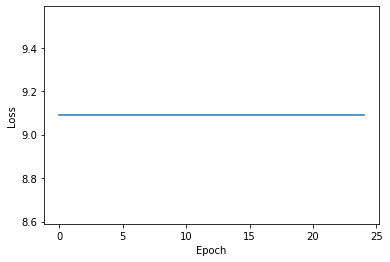

In [22]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

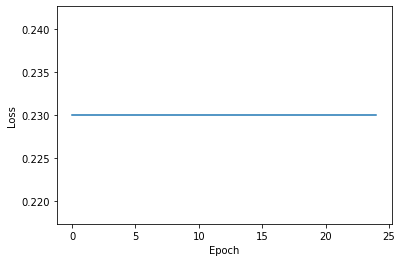

In [23]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [34]:
for a in range(2):
    for b in range(2):
        for c in range(2):
            for d in range(2):
                prediction = qnn([a, b, c, d], theta, 'b')
                inp = f'{a}{b}{c}{d}'
                out = ''.join([str(x) for x in prediction])
                print(f'Input State: |{inp}> \t Output State: |{out}>')

Input State: |0000> 	 Output State: |0011>
Input State: |0001> 	 Output State: |1011>
Input State: |0010> 	 Output State: |0111>
Input State: |0011> 	 Output State: |1111>
Input State: |0100> 	 Output State: |0000>
Input State: |0101> 	 Output State: |1000>
Input State: |0110> 	 Output State: |0100>
Input State: |0111> 	 Output State: |1100>
Input State: |1000> 	 Output State: |0010>
Input State: |1001> 	 Output State: |1010>
Input State: |1010> 	 Output State: |0110>
Input State: |1011> 	 Output State: |1110>
Input State: |1100> 	 Output State: |0001>
Input State: |1101> 	 Output State: |1001>
Input State: |1110> 	 Output State: |0101>
Input State: |1111> 	 Output State: |1101>
